In [1]:
# Deep Learning Fundamentals: MNIST Case Study
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

from tqdm import tqdm
from collections import defaultdict


c:\Users\jules\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### Data Collection

In [2]:
# import requests

# # URLs of the files
# data_train_features_url = 'https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_features.csv'
# data_train_labels_url = 'https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_labels.csv'
# data_test_features_url = 'https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_test_features.csv'

# # Function to download a file
# def download_file(url, file_name):
#     response = requests.get(url)
#     response.raise_for_status()  # Ensure we notice bad responses
#     with open(file_name, 'wb') as file:
#         file.write(response.content)
#     print(f'Downloaded {file_name} from {url}')

# # Downloading the files
# download_file(data_train_features_url, 'module7_exercise_train_features.csv')
# download_file(data_train_labels_url, 'module7_exercise_train_labels.csv')
# download_file(data_test_features_url, 'module7_exercise_test_features.csv')

In [3]:
X = pd.read_csv('module7_exercise_train/module7_exercise_train_features.csv').values
y = pd.read_csv('module7_exercise_train/module7_exercise_train_labels.csv').values.ravel()

### Data Analysis

In [4]:
X.shape

(60000, 784)

In [5]:
y.shape

(60000,)

In [6]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [7]:
def plot_mnist_digits(X, y, num_examples=5, figsize=(15, 3)):
    # Create figure
    fig, axes = plt.subplots(1, num_examples, figsize=figsize)
    
    # Ensure axes is always a numpy array
    if num_examples == 1:
        axes = np.array([axes])
    
    # Plot each example
    for i in range(num_examples):
        # Reshape the flattened image back to 28x28
        img = X[i].reshape(28, 28)
        
        # Plot
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {y[i]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    return fig

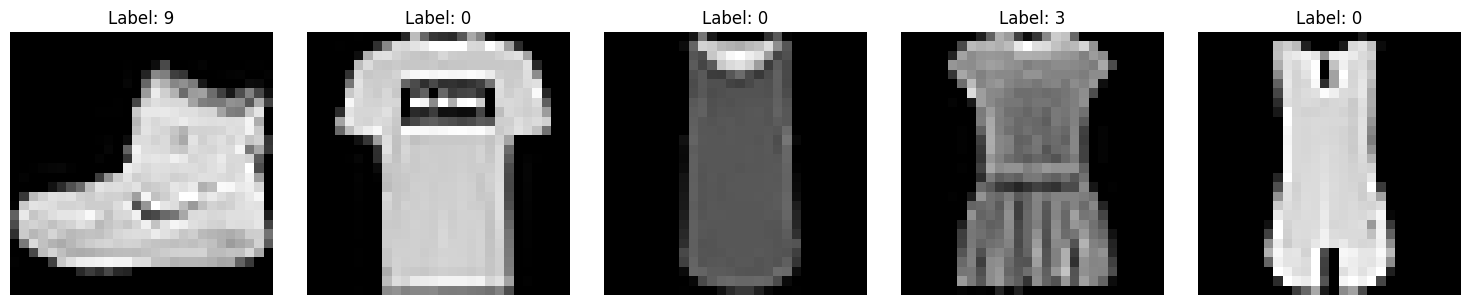

In [8]:
# Plot some examples
fig = plot_mnist_digits(X, y, num_examples=5)
plt.show()

### Data Preprocessing
Scale, split the data and create dataLoaders

In [9]:
def preprocess_data(X, y, batch_size=32, train_size=0.7, val_size=0.15, random_state=42):
    # Split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Convert into tensors
    X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_val_scaled = torch.tensor(X_val_scaled, dtype=torch.float32)
    X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    
    train_data = TensorDataset(X_train_scaled, y_train)
    val_data = TensorDataset(X_val_scaled, y_val)
    test_data = TensorDataset(X_test_scaled, y_test)
    
    data_loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    data_loader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    data_loader_test = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    return data_loader_train, data_loader_val, data_loader_test,X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

### Model
Create a simple model with right input output and define criterion and criterion/loss

In [25]:
def create_model():
    model = nn.Sequential(
        nn.Linear(784,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,10),
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return model, criterion, optimizer

### Train
Create a loop to train your model

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer,num_epochs):
    history = defaultdict(list)
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for inputs,targets in train_loader: # for batch in train_loader
            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = criterion(y_pred,targets)
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train)
            y_predictions_train = torch.argmax(y_pred_train, dim=1)
            train_loss = criterion(y_pred_train, y_train).item()
            train_acc = (y_predictions_train == y_train).float().mean().item()

            y_pred_val = model(X_val)
            y_predictions_val = torch.argmax(y_pred_val, dim=1)
            val_loss = criterion(y_pred_val, y_val).item()
            val_acc = (y_predictions_val == y_val).float().mean().item()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
    return history

### Training

In [29]:
# Create model and training components
model, criterion, optimizer = create_model()

train_loader, val_loader, test_loader, X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(X, y, batch_size=32, train_size=0.7, val_size=0.15, random_state=42)


In [30]:
# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=40
)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [03:58<00:00,  5.96s/it]


###  Visualization

In [23]:
def plot_training_history(history):
    """
    Plot training history
    
    Parameters:
    -----------
    history : dict
        Training history containing metrics
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    return fig

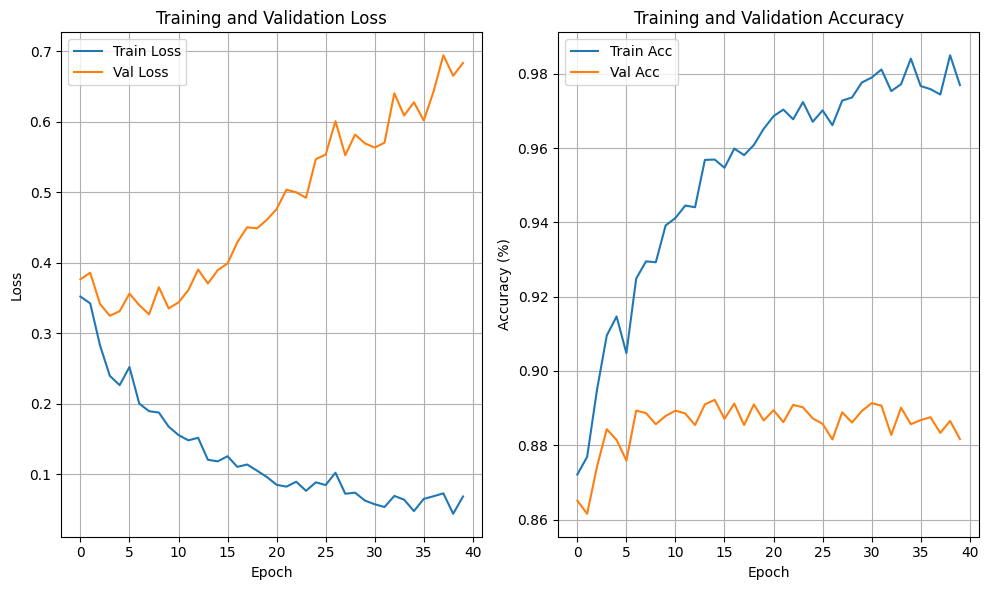

In [31]:
# Plot training history
plot_training_history(history)
plt.show()

### Test

In [32]:
# Test
model.eval()
with torch.no_grad():
    y_pred = torch.argmax(model(X_test),dim=1)

Accuracy : 0.878000020980835


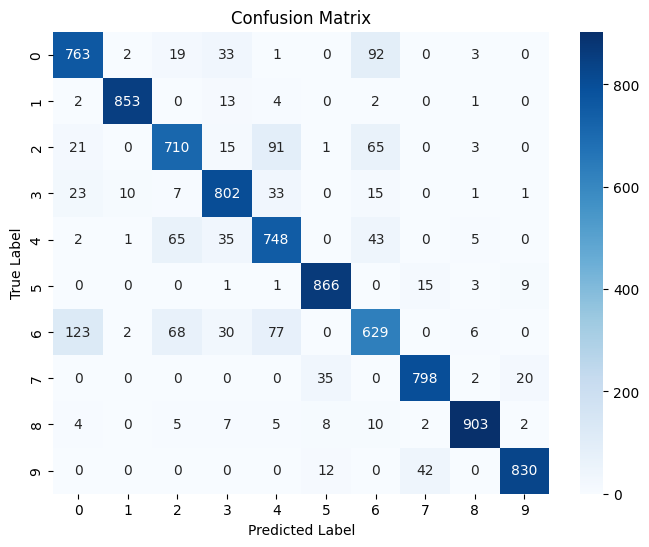

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred,normalize=None)

print("Accuracy :",(y_pred == y_test).float().mean().item())

# 5. Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Model improvements

In [52]:
def create_model_v2():
    model = nn.Sequential(
        nn.Linear(784,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,128),
        nn.ReLU(),
        nn.Dropout(0.5), 
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,10),
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return model, criterion, optimizer

In [53]:
# Create model and training components
model_v2, criterion, optimizer_v2 = create_model_v2()

In [45]:
# On ajoute un early stopping 

def train_model_v2(model, train_loader, val_loader, criterion, optimizer,num_epochs,patience=10):
    history = defaultdict(list)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in tqdm(range(num_epochs)):
        model.train()
        for inputs,targets in train_loader: # for batch in train_loader
            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = criterion(y_pred,targets)
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train)
            y_predictions_train = torch.argmax(y_pred_train, dim=1)
            train_loss = criterion(y_pred_train, y_train).item()
            train_acc = (y_predictions_train == y_train).float().mean().item()

            y_pred_val = model(X_val)
            y_predictions_val = torch.argmax(y_pred_val, dim=1)
            val_loss = criterion(y_pred_val, y_val).item()
            val_acc = (y_predictions_val == y_val).float().mean().item()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
            
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return history

In [54]:
history_2 = train_model_v2(model_v2, train_loader, val_loader, criterion, optimizer_v2,num_epochs=30,patience=10)

 53%|█████▎    | 16/30 [02:51<02:29, 10.69s/it]

Early stopping triggered after 17 epochs


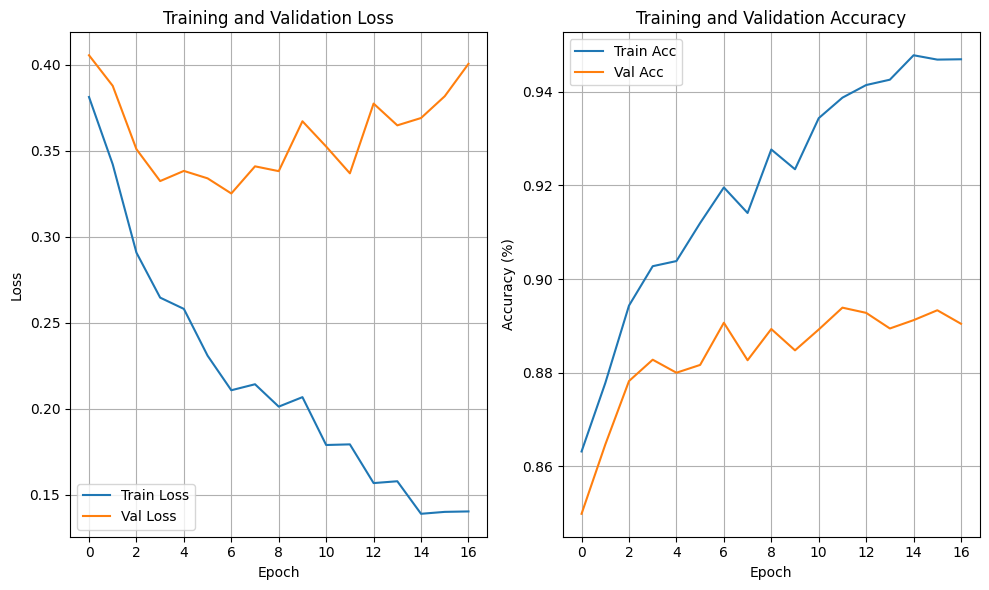

In [55]:
plot_training_history(history_2)
plt.show()

In [56]:
# Test
model.eval()
with torch.no_grad():
    y_pred = torch.argmax(model_v2(X_test),dim=1)

Accuracy : 0.8861111402511597


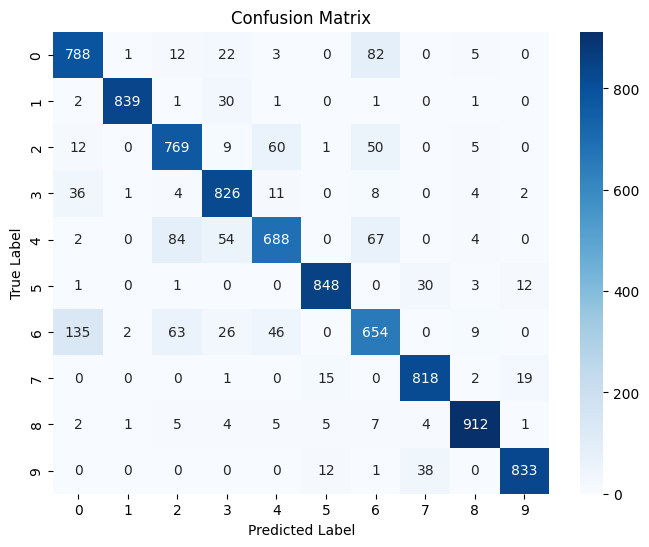

In [57]:
conf_matrix = confusion_matrix(y_test, y_pred,normalize=None)

print("Accuracy :",(y_pred == y_test).float().mean().item())

# 5. Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### Generating Submission File

In [66]:
X_final = pd.read_csv('module7_exercise_test_features.csv')
X_final_tensor = torch.tensor(X_final.values, dtype=torch.float32)

In [67]:
model_v2.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model_v2(X_test_tensor)

In [69]:
predicted_labels = torch.argmax(predictions, dim=1)

In [70]:
submission = pd.DataFrame({
    'index': X_final.index,
    'label': predicted_labels
})

submission.to_csv('submission.csv', index=False, sep=',')
submission.head()

,index,label
0,0,7
1,1,2
2,2,1
3,3,1
4,4,0
